---
layout: single
toc: true
published: true 
header:
  teaser: \assets\images\ML\feedforward_train.png
categories:
  - Machine Learning
tags:
  - Getting Started
  - Modeling
--- 

> All models are wrong, but some are useful. — George E. P. Box

# Generative Models

A **model** is a set of assumptions (and, usually, equations) which frame the way the world works. For example, you might model a series of dice rolls in a board game by assuming they are independent from each other - in other words, the outcome of the first roll does not affect the outcome of the second roll.

However, we'll usually be interested in **generative models.** A generative model with respect to some observed data is a model which is capable of *fully simulating* the observed data. For example, if you observed a bunch of dice rolls in a row, as follows:

$$ 1, \, 3, \, 4, \, 6, \, 2, \, 5, \, 5, \, 3, \, 1, \, 6$$

just knowing that each roll is independent of the others is *not* enough to simulate the data. To do that, you'd need to also to specify the *probability distribution* of the value of each roll - in other words, the probability that any roll will land as a $1$ or a $2$ or a $3$, etc. 

We like generative models for at least two reasons! First, they let us do fun (and useful) math - for example, we can estimate the probability that the observed data occurs under a model. As we'll see, calculating the likelihood of observed data is extremely important in techniques like Maximum Likelihood Estimation and more. Second, generative models can also *do* cool things: for example, a generative model for natural language can [write a chapter of Harry Potter](https://medium.com/deep-writing/harry-potter-written-by-artificial-intelligence-8a9431803da6) or even create [fake pictures of real celebrities](https://www.youtube.com/watch?v=VrgYtFhVGmg), as pictured below:

![png](\assets\images\ipython\2018-09-17-probabilistic-modeling_files\fake-celebrities.PNG)

These fake celebrities came from a paper at [arXiv:1710.10196](https://arxiv.org/abs/1710.10196).

# The Data Generating Process

The **Data Generating Process** (DGP) is the "true" generative model. To be more specific, in most problems we assume there is some underlying joint probability distribution which governs the data we observe, and the DGP is that underlying distribution. The DGP is a bit like the government in this sense - we can never know exactly what it's doing internally, but we can use external data to get a rough sense of what's going on.

In the example in the next section, which will tie together all of this material, we have a "God's eye view" and can see the DGP in all its glory, but only because I literally made up the data. In reality, you will never know the DGP - the point of ML is broadly to create models which approximate it. We call a model *correctly specified* if it has the same underlying structure as the DGP.

# Estimators, Parametric, and Nonparametric Models

Like people, models tend to come in families. For example, the normal distribution is not a single distribution - it's a family of extremely similar distributions, each of which depends on two values: a *mean* and *variance.* We generally call values which help index families of models *parameters*. 

Unfortunately, we don't usually know the values of parameters we're interested in. As a result, we have to create *estimates* for parameter values. We do this using *estimators*, which are just functions of random data which we can use to guess the parameter of interest. Usually, we denote estimators by putting a little hat on top of some symbol, like $\hat \theta$ or $\hat \sigma$.  

To understand all of the modeling terminology we've been discussing, consider the example below.

<div class = 'notice--warning'> Warning: the term "estimator" is extremely confusing. The key point to remember is that an <strong> estimate </strong> is nonrandom, whereas an <strong> estimator </strong> is a function of
random data. Both serve as a guess for a parameter of interest. This is all made more confusing by the fact that some people refer to values they want to learn as <strong> estimands </strong>. </div>

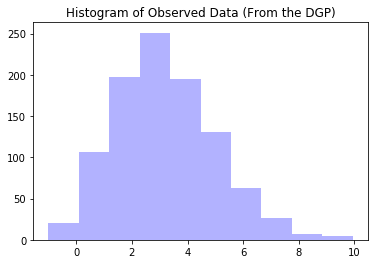

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(210)

# Simulate data w random noise
num_samples = 1000
true_lambda = np.pi 
data = np.random.poisson(true_lambda, size = num_samples) 
data = data + 0.5*np.random.randn(num_samples) 
plt.hist(data, color = 'blue', alpha = 0.3)
plt.title("Histogram of Observed Data (From the DGP)")
plt.show()

Let's try fitting two models to this data. 

In the first model, we'll make a big (but correct!) assumption: that the DGP is primarily a Poisson Distribution. However, we need to find the rate parameter for the Poisson distribution. We'll talk more about different types of estimators in the coming posts, but one commonly used estimator is simply the mean of the data. This makes intuitive sense, because the mean of a Poisson is its rate parameter. Then, if we denote our parameter as $\lambda$, our $n$ data points as $X_1, \dots, X_n$, and our estimator as $\hat \lambda$, we define

$$ \hat \lambda = \frac{1}{n} \sum_{i = 1}^n X_n$$

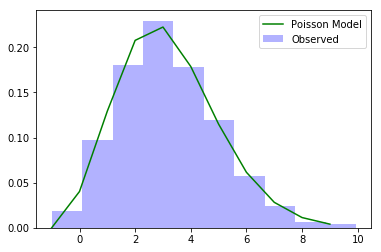

In [6]:
from scipy import stats

# Draw values from model dist
hat_lambda = data.mean()
def model_pmf(x): return stats.poisson.pmf(x, hat_lambda, loc=0)
x_values = np.arange(-1, 10, 1).astype(np.float64)
model_pmf_values = model_pmf(x_values)

# Plot
fig, ax = plt.subplots()
ax.hist(data, color = 'blue', alpha = 0.3, density = True, label = 'Observed')
ax.plot(x_values, model_pmf_values, color = 'green', alpha = 1, label = 'Poisson Model')
ax.legend()
plt.show()

In our second model, we'll make fewer assumptions about the underlying distribution of the data. (This model is also a bit more complicated). We will model the density function underlying the data by simply calculating the percent of data which falls into a small bin around the data. In this setting, our estimand is the shape of the distribution itself: we're modeling the entire distribution in one go. (This is a simple example of __kernal density estimation (kde)__, which we'll talk more about later). 

To get a little bit more formal, suppose we have observed data $X_1, \dots, X_n$ and we have selected a binsize of $h$ (usually, the more data you have observed, the smaller you make the binsize). Then, for any real number $y$, our estmimator, called $\hat f$, returns the following expression:

$$ \hat f(y) = \frac{1}{h} \sum_{i=1}^n \frac{I_{|X_i - y| < h/2}} {n} $$

This notation may be a bit confusing at first, but remember that $I_{X_i \in (a_i, b_i])} $ is just an indicator random variable which equals $1$ if the $n$th data observation $X_n$ falls within $\frac{h}{2}$ of the input $y$, and $0$ otherwise. Let's see how this model performs below, especially compared against the Poisson model:

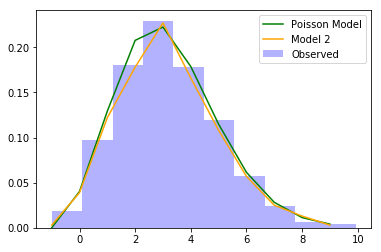

In [8]:
from sklearn.neighbors.kde import KernelDensity

# Model 2 - Rectangular KDE 
bandwidth = 1.06 * data.std() * num_samples ** (-1/5)
def f_hat(y): 
    return sum(1 for x in data if abs(x - y) < bandwidth)/len(data)

f_hat = np.vectorize(f_hat)
model2_values = f_hat(x_values)

fig, ax = plt.subplots()
ax.hist(data, color = 'blue', alpha = 0.3, density = True, label = 'Observed')
ax.plot(x_values, model_pmf_values, color = 'green', alpha = 1, label = 'Poisson Model')
ax.plot(x_values, model2_values, color = 'orange', alpha = 1, label = 'Model 2')
ax.legend()
plt.show()

Both models perform reasonably well, probably because in these kinds of examples, we have the luxury of actually knowing the DGP and can model accordingly. 

However, there is one key difference to note between the two models. In the first model, no matter how much data we observe, we only have one parameter: the rate parameter for the Poisson. On the other hand, in the second model, our binsize gets smaller and smaller the more data we observe. As a result, the number of output values we have to estimate for the function actually scales with the size of the data; so if we observed an infinite amount of data, we'd have to estimate an infinite number of values, i.e. each value $\hat f(y)$ for any $y \in \mathbb{R}$.

This difference between the models is so important it has a name. Because the first model only has a *finite* number of parameters, it is called a **parametric model.** On the other hand, as we observe more data, the second model has an unbounded number of parameters. As a result, it is called a **nonparametric model.**

# Supervised and Unsupervised Learning

One last important distinction worth reviewing is the difference between **supervised** and **unsupervised** learning algorithms. (The distinction's a bit artificial, but the terminology is so common it's worth reviewing). 

Unsupervised algorithms are designed to automatically detect patterns in data that has already been observed. For example, the following algorithm (called a Gaussian Mixture Model, or GMM) can take the following data as an input:

{% raw %}![](/assets/images/ML/unsup_init_data.png){% endraw %}

and the GMM will automatically cluster it into something like the following:

{% raw %}![](/assets/images/ML/gmm_output.png){% endraw %}

The GMM did not require any training data; it simply detected the underlying clusters in the data. 

On the other hand, supervised learning algorithms are designed to solve a different kind of problem. Imagine you have observed a variety of points in space, each associated with a specific color. We will represent the location of each point as $X_i$, and the color as $Y_i$. The goal in a supervised learning problem is to learn to predict $Y$ given $X$: in other words, if you observe the locations of a bunch of new points in space, predict the new colors of the points.

For example, a simple feedforward neural network might receive the following points as training data:
{% raw %}![](/assets/images/ML/feedforward_train.png){% endraw %}
Then, if you fed the network a series of new points like this:
{% raw %}![](/assets/images/ML/feedforward_test.png){% endraw %}
it would be (hopefully) able to predict their color.
{% raw %}![](/assets/images/ML/feedforward_predict.png){% endraw %}

Supervised learning algorithms have a habit of **overfitting** their training data, meaning that the algorithms basically memorizes the output for every training input, but is unable to generalize to new datasets. To detect and prevent overfitting, we often train upsupervised learning algorithms on a partial subset of the training data (maybe ~ 80%) and then test it on the last bit of training data which it has never seen before. 